# Perovskite search space

In this example using SMACT we search the compositional space of possible perovskite (ABX$_3$) structures. The space is limited by chemical and crystallographic criteria.

* We search only for materials with O, S, Se, F, Cl, Br, or I as the X site.
* We search only for materials with a B site which is known to have octahedral coordination, taken from the [data of Shannon.](http://scripts.iucr.org/cgi-bin/paper?a12967)
* We classify the potential structures of the resultant charge neutral combinations based on the ratios of the Shannon radii and the [Goldschmidt tolerance factor.](http://link.springer.com/article/10.1007%2FBF01507527)

In [2]:
%matplotlib inline
import smact.lattice as lattice
import smact.core as core
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools 

label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.color_cycle'] = ['#0C8080','#D66C14', '#1762B0']

## Setting the paths
Here we simply tell the code where to find the data from SMACT.

In [4]:
# get correct path for datafiles when called from another directory
smact_directory = '../../smact'
# Append a trailing slash to make coherent directory name - this would select the
# root directory in the case of no prefix, so we need to check
if smact_directory:
    smact_directory = smact_directory + '/'

## Setting up the perovskite lattice
SMACT lattice is an object which contains information about the positions of the lattice sites, the oxiation states of the potential species at those sites and the spacegroup of the lattice. It can be used to quickly build atomistic models of the results of a screening.

In [5]:
site_A = lattice.Site([0,0,0],[+1,+2,+3])
site_B = lattice.Site([0.5,0.5,0.5],[+5,+4,+3,+2])
site_C = lattice.Site([0.5,0.5,0.5],[-2,-1])
perovskite = lattice.Lattice([site_A,site_B,site_C],space_group=221)

## Set up the chemical space for the search
Initially we search through the first 100 elements blindly. The total number of possible combinations is returned.

In [6]:
search = core.ordered_elements(1,100)
initial_total = len(list(itertools.combinations(search,3)))

## Applying chemical restrictions
We now narrow the search space by applying some chemical criteria. 
1. The X site is either O, S, Se, Cl, Br, or I.
2. The B site is known to have octahedral coordination from the [data of Shannon.](http://scripts.iucr.org/cgi-bin/paper?a12967)

In [7]:
A_list = []
B_list = []
C_list = [['O',-2,1.35],['S',-2,1.84],['Se',-2,1.98],['F','-1',1.29],['Cl',-1,1.81],['Br',-1,1.96],['I',-1,2.2]]
for element in search:
    with open(smact_directory + 'data/shannon_radii.csv','rU') as f:
        reader = csv.reader(f)
        r_shannon=False
        for row in reader:
            if row[0]==element and int(row[1]) in site_A.oxidation_states:
                A_list.append([row[0],row[1],row[4]])
            if row[2]=="6_n" and row[0]==element and int(row[1]) in site_B.oxidation_states:
                B_list.append([row[0],row[1],row[4]])

## Iterative search
Having constructed potential element lists for each of the sites we now do an iterative search through all poaaible combinations, applying different levels of screening.
1. A =/= B.
2. Charge neutrality.
3. Goldschmidt tolerance factors.
4. Environmental screening (greater HHI resource than CZTS).

In [8]:
charge_balanced = []
goldschmidt_cubic = []
goldschmidt_ortho = []
a_too_large = []
A_B_similar = []
pauling_perov = []
anion_stats = []
hhi_czts = 1312
enviro_perovskites = 0
total = 0
for C in C_list:
    Ce = core.Element(C[0])
    anion_hex = 0
    anion_cub = 0
    anion_ort = 0
    anion_env = 0
    for B in B_list:
        Be = core.Element(B[0])
        for A in A_list:
            Ae = core.Element(A[0])
            if B[0] != A[0]:        
                if C[0] != A[0] and C[0] != B[0]:
                    total = total + 1
                    if int(A[1])+int(B[1])+3*int(C[1]) == 0:
                         charge_balanced.append([A[0],B[0],C[0]])
                         paul_a = Ae.pauling_eneg
                         paul_b = Be.pauling_eneg
                         paul_c = Ce.pauling_eneg
                         hhi_a = float(Ae.HHI_R)
                         hhi_b = float(Be.HHI_R)
                         hhi_c = float(Ce.HHI_R)
                         hhi_material = (hhi_a + hhi_b + 3*hhi_c)/5
                         
                         tol = (float(A[2]) + C[2])/(np.sqrt(2)*(float(B[2])+C[2]))
                         if tol > 1.0:
                            a_too_large.append([A[0],B[0],C[0]])
                            anion_hex = anion_hex+1
                         if tol > 0.9 and tol <= 1.0:
                            goldschmidt_cubic.append([A[0],B[0],C[0]])
                            anion_cub = anion_cub + 1
                            if hhi_material < hhi_czts:
                                enviro_perovskites = enviro_perovskites + 1
                                anion_env = anion_env + 1
                         if tol >= 0.71 and tol < 0.9:
                            if hhi_material < hhi_czts:
                                enviro_perovskites = enviro_perovskites + 1
                                anion_env = anion_env + 1
                            goldschmidt_ortho.append([A[0],B[0],C[0]])
                            anion_ort = anion_ort + 1
                         if tol < 0.71:
                            A_B_similar.append([A[0],B[0],C[0]])
    anion_stats.append([anion_hex,anion_cub,anion_ort,anion_env]) 

In [12]:
number_of_perovskites = 0
for i in [0,1,2,3,4,5]:
    for j in [1,2]:
        number_of_perovskites = anion_stats[i][j] + number_of_perovskites
        
number_hex = 0
for i in [0,1,2,3,4,5]:
    number_hex = number_hex + anion_stats[i][0]
    
number_cubic = 0
for i in [0,1,2,3,4,5]:
    number_cubic = number_cubic + anion_stats[i][1]
    
number_ortho = 0
for i in [0,1,2,3,4,5]:
    number_ortho = number_ortho + anion_stats[i][2]

## Look at the results

In [13]:
print "Total number before any screening: ", initial_total
print "Total number after initial selection of chemical criteria: ", len(list(itertools.product(A_list,B_list,C_list)))
print "Total number after charge neutrality: ", len(charge_balanced)
#print "Total number after electronegativity criterion applied: ", len(pauling_perov)
print "Total number after Goldschmidt allowed combinations: ", number_of_perovskites
print "Total number after environmental factors: ", enviro_perovskites

Total number before any screening:  161700
Total number after initial selection of chemical criteria:  285215
Total number after charge neutrality:  41397
Total number after Goldschmidt allowed combinations:  26345
Total number after environmental factors:  5689


## Structure

Plot pie charts of the percentages of different structure types based on anion. There is a clear trend towards decreasing percentage of hexagonal structures (predicted from the Goldschmidt factor) as the anion radius increases.

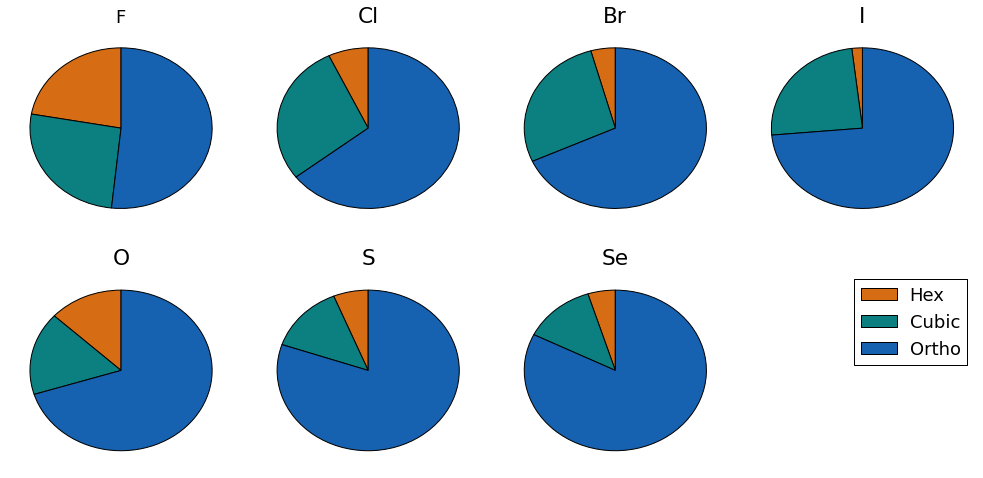

In [20]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 4)
f.set_size_inches(14,7)
colours=['#D66C14', '#0C8080', '#1762B0']
mpl.rcParams.update({'font.size': 18})


axarr[0,0].set_title('F',fontsize=18)
axarr[0,1].set_title('Cl')
axarr[0,2].set_title('Br')
axarr[0,3].set_title('I')
axarr[1,0].set_title('O')
axarr[1,1].set_title('S')
axarr[1,2].set_title('Se')

axarr[1,0].pie(anion_stats[0][:3]
        ,startangle=90,colors=colours)
axarr[1,1].pie(anion_stats[1][:3]
        ,startangle=90,colors=colours)
axarr[1,2].pie(anion_stats[2][:3]
        ,startangle=90,colors=colours)


axarr[0,0].pie(anion_stats[3][:3]
        ,startangle=90,colors=colours)
axarr[0,1].pie(anion_stats[4][:3]
        ,startangle=90,colors=colours)
axarr[0,2].pie(anion_stats[5][:3]
        ,startangle=90,colors=colours)
axarr[0,3].pie(anion_stats[6][:3]
        ,startangle=90,colors=colours)


pie = axarr[1,3].pie(anion_stats[5],radius=0.01
        ,startangle=90,colors=colours)
axarr[1,3].legend(['Hex','Cubic','Ortho'],fontsize=18)
for group in pie:
    for x in group:
        x.set_visible(False)
plt.tight_layout()
plt.savefig('PieCharts.png')

## Plotting the numbers

On the left looking at the raw numbers as we go through the screening procedure. Initially the inclusion of oxidation state data increases the possible number of materials. However, by combining it with charge neutrality we drastically reduce the numbers. Further screening is achieved by considering only materials with a tolerance factor of > 0.7  and < 1.0 as perovskites. Finally we also demonstrate the applicaiton of an environmental sustainability screening criterion. The HHI factor accounts for the resource stability and abundance of elements. Materials HHI is calculated as the stoiciometrically weighted average of the constituent elements. As a threshold we take a value of 1312, which is the HHI of CZTS; a promising sustainable photovoltaic material.

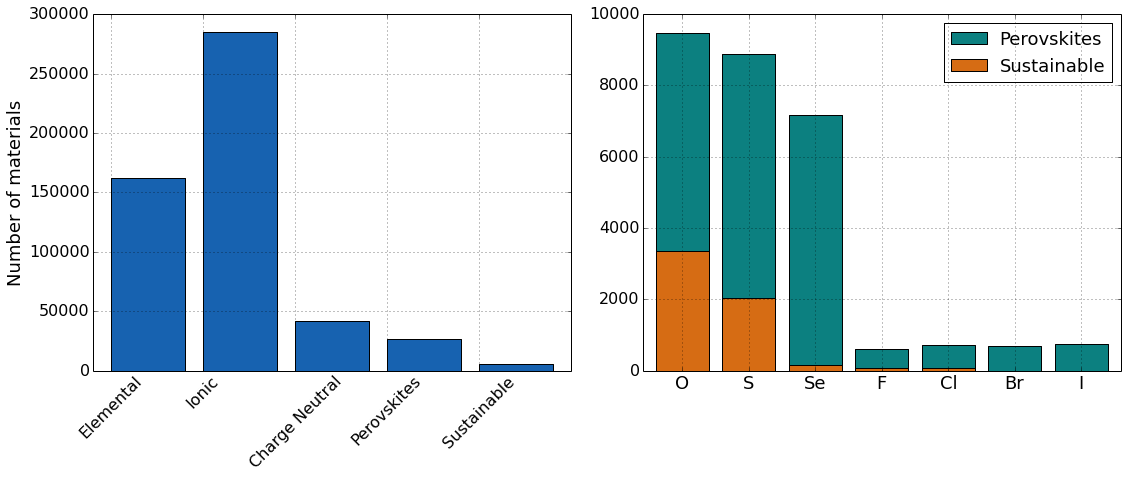

In [21]:
f, ax = plt.subplots(1, 2, sharex=False)
f.set_size_inches(16,7)

totals = [initial_total,len(list(itertools.product(A_list,B_list,C_list))),len(charge_balanced),number_of_perovskites,enviro_perovskites]
labels = ['Elemental','Ionic','Charge Neutral','Perovskites','Sustainable']
ind = np.arange(5)
ax[0].bar(ind,totals,color='#1762B0')
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_xlim(-0.2, 5)
ax[0].grid(True)
ax[0].set_ylabel('Number of materials')

tots = []
for i in np.arange(7):
    tots.append(anion_stats[i][2]+anion_stats[i][3])

enviros = (anion_stats[0][3],anion_stats[1][3],anion_stats[2][3],anion_stats[3][3],anion_stats[4][3],anion_stats[5][3],anion_stats[6][3])
ind = np.arange(7)
p1 = ax[1].bar(ind,tots,color='#0C8080')
p2 = ax[1].bar(ind,enviros,color='#D66C14')
ax[1].set_xticks([0.4,1.4,2.4,3.4,4.4,5.4,6.4])
ax[1].set_xticklabels(['O', 'S', 'Se', 'F', 'Cl','Br','I'],fontsize=18)
ax[1].legend((p1[0],p2[0]),('Perovskites','Sustainable'),fontsize=18)
ax[1].set_xlim(-0.2, 7)
ax[1].grid(True)
plt.tight_layout()
plt.savefig('BarCharts.png')

In [22]:
print tots

[9465, 8867, 7165, 592, 724, 691, 745]


In [28]:
print enviros
for i, a in enumerate(enviros):
    print float(a)/float(tots[i])

(3361, 2033, 157, 68, 70, 0, 0)
0.355097728473
0.229277094846
0.021912072575
0.114864864865
0.0966850828729
0.0
0.0


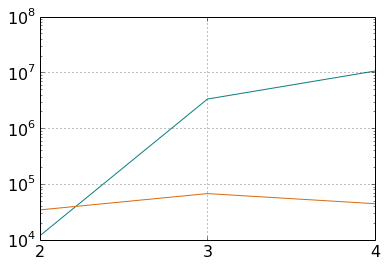

In [40]:
ICSD = [34367, 67347, 44388]
SMACT = [11887,3329381,10561582]
x = [2,3,4]
y = [1e-6,1e-6,1e-6]
plt.semilogy(x,SMACT)
plt.semilogy(x,ICSD)
plt.xticks([2,3,4])
#plt.fill(y,SMACT,'#0C8080',alpha=0.6)
plt.grid(True)